In [1]:
"""
*******************************************************************************

Project: RL, assignment 1
File: warehouse_robot_env.ipynb
Author: Hamid Manouchehri
Email: hmanouch@buffalo.edu
Date: Feb 7, 2025

Description:
Checkpoint 1, preparing an RL environment
Environmet Scenario: Warehouse Robot

License:
This script is licensed under the MIT License.
You may obtain a copy of the License at
    https://opensource.org/licenses/MIT

SPDX-License-Identifier: MIT

Disclaimer:
This software is provided "as is", without warranty of any kind, express or
implied, including but not limited to the warranties of merchantability,
fitness for a particular purpose, and noninfringement. In no event shall the
authors be liable for any claim, damages, or other liability, whether in an
action of contract, tort, or otherwise, arising from, out of, or in connection
with the software or the use or other dealings in the software.

*******************************************************************************
"""

'\n*******************************************************************************\n\nProject: RL, assignment 1\nFile: warehouse_robot_env.ipynb\nAuthor: Hamid Manouchehri\nEmail: hmanouch@buffalo.edu\nDate: Feb 7, 2025\n\nDescription:\nCheckpoint 1, preparing an RL environment\nEnvironmet Scenario: Warehouse Robot\n\nLicense:\nThis script is licensed under the MIT License.\nYou may obtain a copy of the License at\n    https://opensource.org/licenses/MIT\n\nSPDX-License-Identifier: MIT\n\nDisclaimer:\nThis software is provided "as is", without warranty of any kind, express or\nimplied, including but not limited to the warranties of merchantability,\nfitness for a particular purpose, and noninfringement. In no event shall the\nauthors be liable for any claim, damages, or other liability, whether in an\naction of contract, tort, or otherwise, arising from, out of, or in connection\nwith the software or the use or other dealings in the software.\n\n****************************************

In [ ]:
!pip install gymnasium matplotlib numpy

: 

In [1]:
#!/usr/bin/env python3

import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import matplotlib.colors as mcolors
from IPython.display import clear_output

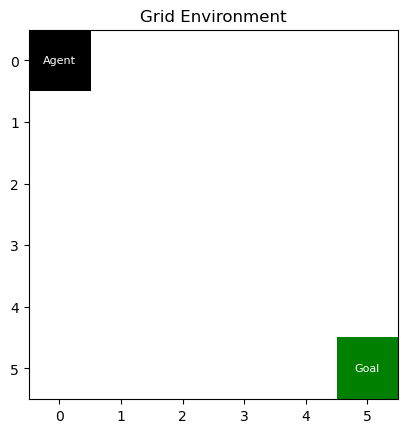

In [2]:
grid_size = 6
grid = np.ones((grid_size, grid_size, 3))
# Define grid size
grid_size = 6  # 6x6 grid

# Initialize grid with default background (White = 4)
grid = np.full((grid_size, grid_size), 1, dtype=int)  # Default to background

# Define agent and goal positions
init_agent_pos = [0, 0]  # Start position
goal_pos = [5, 5]  # Goal position

# Define integer-based color mapping
rgb_colors = {
    "black": 0,   # Agent
    "white": 1,   # Goal
    "red": 2,     # Trap
    "blue": 3,    # Water
    "green": 4,   # Background
    "gray": 5     # Obstacle
}

# Define color list for visualization
color_map = {
    0: "black",
    1: "white",
    2: "red",
    3: "blue",
    4: "green",
    5: "gray"
}

agent_obj_state = {
    0: "no_obj",
    1: "have_obj"
}

# Assign integer values to the grid
grid[tuple(init_agent_pos)] = rgb_colors["black"]  # Agent
grid[tuple(goal_pos)] = rgb_colors["green"]  # Goal

# Create a colormap using actual colors
cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])

for i in range(6):  # rows
    for j in range(6):  # columns
        text = ""
        if [i, j] == init_agent_pos:
            text = "Agent"
        elif [i, j] == goal_pos:
            text = "Goal"
        
        # Only annotate if there is text to display
        if text:
            plt.text(j, i, text, ha="center", va="center", color="white", fontsize=8)


# Display the grid with correct colors
plt.imshow(grid, cmap=cmap, vmin=0, vmax=len(color_map) - 1)
plt.title("Grid Environment")
plt.show()


In [3]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):
        # Initializes the class
        # Define action and observation space
        self.observation_space = spaces.Discrete(36)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 500  # TODO
        self.reward = 0
        
        self.timestep = 0
        self.agent_carry_obj = False
        self.agent_pos = [0,0]
        self.goal_pos = [5,5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]

        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]


    # Reset function
    def reset(self, **kwargs):
        self.agent_carry_obj = False
        self.agent_pos = [0,0]
        self.goal_pos = [5,5]
        self.object_pos = [1, 2]
        self.obstacle_1_pos = [2, 2]
        self.reward = 0
        self.timestep = 0
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]
        observation = np.append(int(self.agent_carry_obj),np.array(self.agent_pos))

        
        info = {}
        
        return observation, info


    def pick_up_obj(self):
        self.state[tuple(self.object_pos)] = rgb_colors["white"]
        self.agent_carry_obj = True


    def drop_off_obj(self):
        self.state[tuple(self.goal_pos)] = rgb_colors["white"]
        self.agent_carry_obj = False


    def step(self, action):
        self.reward -= 1
        terminated = False

        # Compute the potential new position based on the action.
        new_agent_pos = self.agent_pos.copy()
        if action == 0:  # down
            new_agent_pos[0] += 1
        elif action == 1:  # up
            new_agent_pos[0] -= 1
        elif action == 2:  # right
            new_agent_pos[1] += 1
        elif action == 3:  # left
            new_agent_pos[1] -= 1

        # Ensure the new position is within bounds.
        new_agent_pos = np.clip(new_agent_pos, 0, 5).tolist()

        # Obstacle avoidance: If the new position is the obstacle, do not update agent_pos.
        if np.array_equal(new_agent_pos, self.obstacle_1_pos):
            self.reward -= 25  # Apply penalty
            # Optionally, you might decide to leave the agent in place:
            # new_agent_pos remains as the current position.
        else:
            # Otherwise, update the agent's position.
            self.agent_pos = new_agent_pos

        # Update the grid state.
        self.state = np.ones((6,6))
        self.state[tuple(self.agent_pos)] = rgb_colors["black"]
        self.state[tuple(self.goal_pos)] = rgb_colors["green"]
        if not self.agent_carry_obj:
            self.state[tuple(self.object_pos)] = rgb_colors["blue"]
        self.state[tuple(self.obstacle_1_pos)] = rgb_colors["red"]

        # Create the observation.
        observation = np.append(int(self.agent_carry_obj), np.array(self.agent_pos))

        # Check for picking up the object.
        if np.array_equal(self.agent_pos, self.object_pos) and (self.agent_carry_obj == False):
            self.pick_up_obj()
            self.reward += 25
            self.state[tuple(self.object_pos)] = rgb_colors["white"]

        # Check for dropping off the object.
        if np.array_equal(self.agent_pos, self.goal_pos) and (self.agent_carry_obj == True):
            self.drop_off_obj()
            self.reward += 100
            terminated = True
            self.state[tuple(self.goal_pos)] = rgb_colors["black"]

        # Termination condition based on timestep.
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            terminated = True

        # Check if agent remains within permitted cells.
        if np.all((np.asarray(self.agent_pos) >= 0) & (np.asarray(self.agent_pos) <= 5)):
            truncated = True
        else:
            truncated = False

        info = {}
        return observation, self.reward, terminated, truncated, info



    # Render function: Visualizes the environment
    def render(self):

        cmap = mcolors.ListedColormap([color_map[i] for i in range(len(color_map))])
        plt.imshow(self.state, cmap=cmap, vmin=0, vmax=len(color_map) - 1)
        
        # Annotate the grid with text labels
        for i in range(6):  # rows
            for j in range(6):  # columns
                label = ""
                if np.array_equal([i, j], self.agent_pos):
                    label = "Agent"
                elif np.array_equal([i, j], self.goal_pos):
                    label = "Goal"
                elif np.array_equal([i, j], self.object_pos):
                    label = "Obj"
                elif np.array_equal([i, j], self.obstacle_1_pos):
                    label = "Obs"
                
                if label:
                    plt.text(j, i, label, ha="center", va="center", color="white", fontsize=8)
        
        plt.title("Grid Environment")
        plt.show()

In [38]:
def get_state_index(obs, index_lookup_table):
            
    return index_lookup_table[obs[0],obs[1],obs[2]]


def q_learning(env, num_episodes=1000, max_steps=100, alpha=0.1, gamma=0.99,
               epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995,det=0):
        """
        Performs Q-learning on a given environment.
        
        Parameters:
        env: The environment instance (should have reset, step, and get_state_index-like behavior)
        num_episodes: Number of episodes for training.
        max_steps: Maximum steps per episode.
        alpha: Learning rate.
        gamma: Discount factor.
        epsilon: Initial exploration rate.
        epsilon_min: Minimum exploration rate.
        epsilon_decay: Decay factor for epsilon after each episode.
        
        Returns:
        Q: The trained Q-table.
        rewards_all_episodes: List with total rewards per episode.
        """
        index_lookup_table = np.arange(72).reshape((2,6,6))
        grid_size = 6
        num_states = grid_size * grid_size
        num_actions = env.action_space.n  # 4 actions
        
        # Initialize Q-table with zeros.
        Q_table = np.zeros((num_states*2, num_actions))
        rewards_all_episodes = []            
        
        for episode in range(num_episodes):
            obs, info = env.reset()
            state_idx = get_state_index(obs, index_lookup_table)
            total_rewards = 0
            for step in range(max_steps):
                # Epsilon-greedy action selection.
                
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q_table[state_idx, :])
                
                if np.random.rand() < det:# Stochastic
                    reward=-1
                else:
                    obs, reward, terminated, truncated, info = env.step(action)

                # print("agent location: ", env.agent_pos, "action", action)
                
                total_rewards += reward
                new_state_idx = get_state_index(obs, index_lookup_table)
                
                # Q-learning update rule.
                Q_table[state_idx, action] += alpha * (
                    reward + gamma * np.max(Q_table[new_state_idx, :]) - Q_table[state_idx, action]
                )
                
                state_idx = new_state_idx
                
                if terminated:# or truncated:
                    break
            
            # Decay epsilon after each episode.
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            rewards_all_episodes.append(total_rewards)
        
        return Q_table, rewards_all_episodes

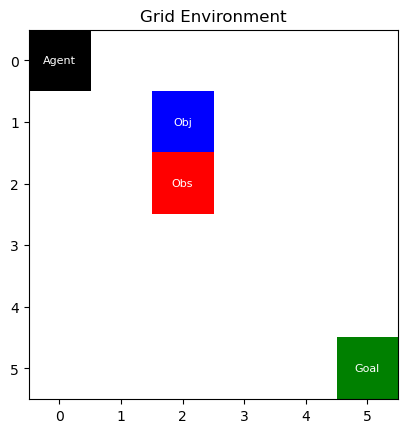

In [64]:
##############################
## Init environment & Reset ##
##############################
env = GridEnvironment()
terminated, truncated = False, False
observation, info = env.reset()
env.render()

In [ ]:
def SARSA(env, num_episodes=1000, max_steps=100, alpha=0.1, gamma=0.99,
               epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        """
        Performs Q-learning on a given environment.
        
        Parameters:
        env: The environment instance (should have reset, step, and get_state_index-like behavior)
        num_episodes: Number of episodes for training.
        max_steps: Maximum steps per episode.
        alpha: Learning rate.
        gamma: Discount factor.
        epsilon: Initial exploration rate.
        epsilon_min: Minimum exploration rate.
        epsilon_decay: Decay factor for epsilon after each episode.
        
        Returns:
        Q: The trained Q-table.
        rewards_all_episodes: List with total rewards per episode.
        """
        index_lookup_table = np.arange(72).reshape((2,6,6))
        grid_size = 6
        num_states = grid_size * grid_size
        num_actions = env.action_space.n  # 4 actions
        
        # Initialize Q-table with zeros.
        Q_table = np.zeros((num_states*2, num_actions))
        rewards_all_episodes = []
        
        def get_state_index(obs):
            
            # print(type(obs))
            return index_lookup_table[obs[0],obs[1],obs[2]]
            
        
        for episode in range(num_episodes):
            obs, info = env.reset()
            state_idx = get_state_index(obs)
            total_rewards = 0
            for step in range(max_steps):
                # Epsilon-greedy action selection.
                
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q_table[state_idx, :])
                
                if np.random.rand() < 0:# Stochastic
                    reward=-1
                    print('wakka wakka whatever')
                else:
                    obs, reward, terminated, truncated, info = env.step(action)

                print("agent location: ", env.agent_pos, "action", action)
                
                total_rewards += reward
                new_state_idx = get_state_index(obs)
                
                # Q-learning update rule.
                Q_table[state_idx, action] += alpha * (
                    reward + gamma * np.max(Q_table[new_state_idx, :]) - Q_table[state_idx, action]
                )
                
                state_idx = new_state_idx
                
                if terminated:# or truncated:
                    break
            
            # Decay epsilon after each episode.
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            rewards_all_episodes.append(total_rewards)
        
        return Q_table, rewards_all_episodes

In [65]:
def test(Q_table, num_episodes=10, max_steps=100, det=0):

    
    index_lookup_table = np.arange(72).reshape((2,6,6))
    rewards_all_episodes = []
    
    for episode in range(num_episodes):
        terminated = 0
        obs, info = env.reset()
        state_idx = get_state_index(obs, index_lookup_table)
        total_rewards = 0
        for step in range(max_steps):
            
            action = np.argmax(Q_table[state_idx, :])
            
            if np.random.rand() < det:  # Stochastic
                reward=-1
            else:
                obs, reward, terminated, truncated, info = env.step(action)

            # print("agent location: ", env.agent_pos, "action", action)
            
            total_rewards += reward
            new_state_idx = get_state_index(obs, index_lookup_table)
            
            
            state_idx = new_state_idx
            
            if terminated:# or truncated:
                break
        
        # Decay epsilon after each episode.
        rewards_all_episodes.append(total_rewards)

    
    return  rewards_all_episodes

[[ 216.9447019   173.88133971  148.27264499  169.91754482]
 [ 193.33365998  100.83396346   56.79522572   95.747386  ]
 [ 118.2965908   -97.15035821  -96.71161599  -69.3425477 ]
 [ -97.71805312 -100.6653961   -98.09658965  -97.3610712 ]
 [ -96.49232716  -90.0838337  -106.50783702  -96.37263619]
 [-131.88224972 -108.45002003 -118.65390331 -106.9531432 ]
 [  33.91413279  115.4443214   221.11979978  141.10767618]
 [ 114.02277007  136.46556537  226.20737481  155.55135019]
 [ 122.39257789   11.1746251   207.22856389  -42.08616973]
 [ -97.68367032  -95.89296945 -103.80786035  -88.74492988]
 [-100.941231   -104.69701043  -96.87556126  -99.56623818]
 [-101.51752794 -128.99063933 -101.77383531  -90.16736055]
 [-135.73900872  138.78602633 -137.36634469  -95.38713287]
 [-126.37838068  155.22629893 -114.18967956 -141.3074898 ]
 [   0.            0.            0.            0.        ]
 [-125.31828744 -113.19467115 -118.31703625 -136.27769158]
 [-109.57954218 -113.25722348 -101.39965682 -128.1285140

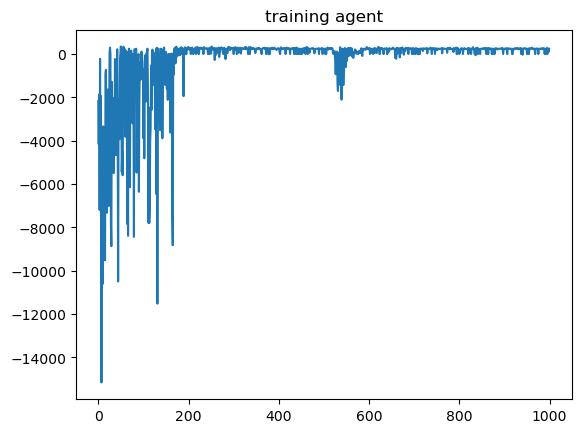

Text(0.5, 1.0, 'test agent')

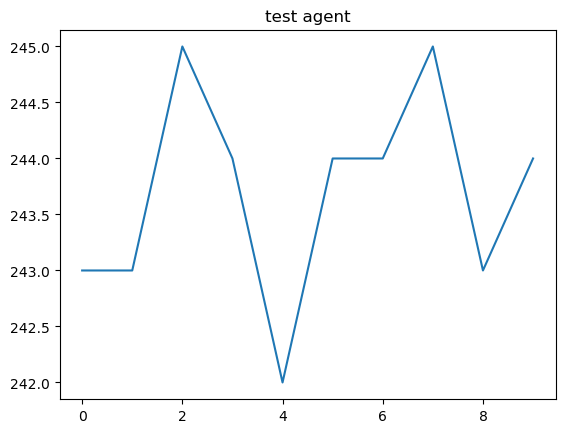

In [69]:
##############################
#### Q-Learning Training #####
##############################
det=0.1
Q_table, rewards_all_episodes = q_learning(env, det=det)
plt.plot(rewards_all_episodes)
print(Q_table)
plt.title('training agent')

pkl_file_name = 'Q_table.pkl'
dir_to_save_pkl_file = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/scripts/data/"
with open(dir_to_save_pkl_file + pkl_file_name, 'wb') as f:
    pickle.dump(Q_table, f)

# with open(dir_to_save_pkl_file + pkl_file_name, 'rb') as f:
#     Q_table = pickle.load(f)

plt.show()
t=test(Q_table, num_episodes=10, max_steps=100, det=det)
plt.plot(t)
plt.title('test agent')


[[ 217.05592778  188.64242543  151.81378409  191.89042068]
 [ 211.59842299 -164.41136806 -170.0128629   -39.16086465]
 [-164.1990796  -167.20918849 -162.25526953 -163.14430224]
 [-161.96918002 -170.35816789 -178.3307471  -170.88943032]
 [-172.38769168 -176.93659231 -176.84556635 -177.65990615]
 [-182.13765261 -181.33581587 -184.18162812 -184.55905472]
 [  91.3259222   187.39978967  219.69821702  161.80790467]
 [  99.61750514  167.00809611  223.19403278  174.72814703]
 [ 136.27056221  108.02582458  202.94818577   91.21027095]
 [-163.38148635 -167.63702048 -161.09166113 -104.1051787 ]
 [-161.01322052 -157.88789384 -159.47099276 -167.51031683]
 [-163.2166922  -199.72303486 -165.62829838 -149.31830271]
 [-188.00556994  171.89266124 -160.33160201 -158.09280009]
 [-184.28787096  182.37890242 -191.71069561 -186.8890448 ]
 [   0.            0.            0.            0.        ]
 [-166.80742418 -175.54298123 -173.48643186 -167.58793483]
 [-168.16169762 -168.6256105  -171.50580138 -175.6868116

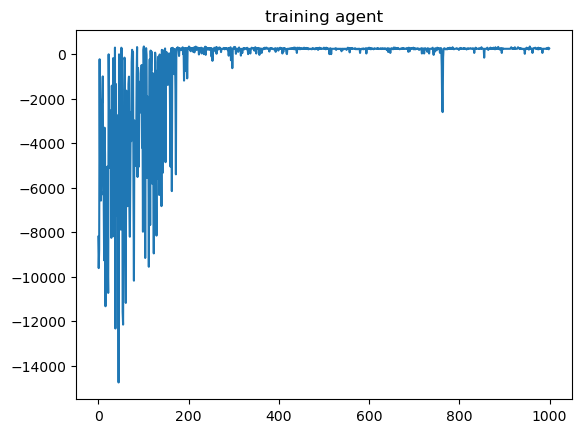

Text(0.5, 1.0, 'test agent')

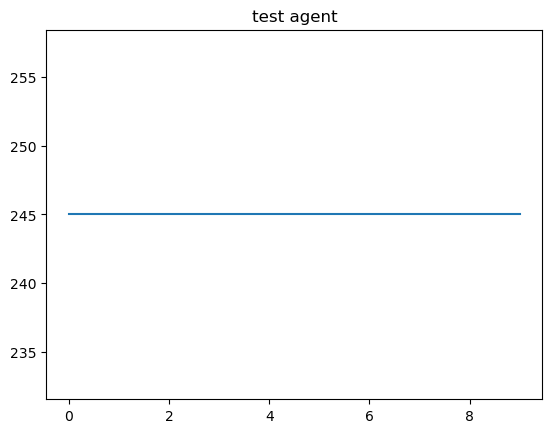

In [71]:
det=0.
Q_table, rewards_all_episodes = q_learning(env, det=det)
plt.plot(rewards_all_episodes)
print(Q_table)
plt.title('training agent')

pkl_file_name = 'Q_table.pkl'
dir_to_save_pkl_file = "/home/hamid/UB/courses/sp2025/CSE546_RL/RL/scripts/data/"
with open(dir_to_save_pkl_file + pkl_file_name, 'wb') as f:
    pickle.dump(Q_table, f)

# with open(dir_to_save_pkl_file + pkl_file_name, 'rb') as f:
#     Q_table = pickle.load(f)

plt.show()
t=test(Q_table, num_episodes=10, max_steps=100, det=det)
plt.plot(t)
plt.title('test agent')

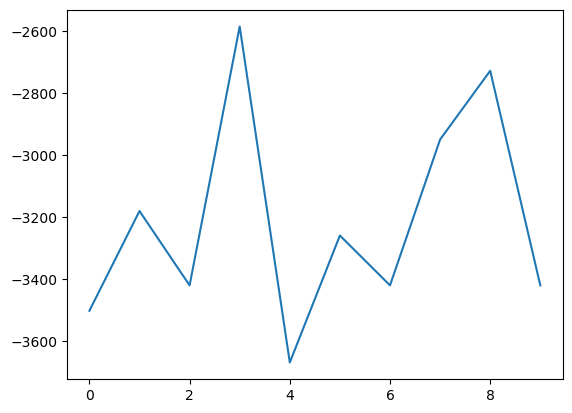

In [67]:
t=test(Q_table, num_episodes=10, max_steps=100, det=0.2)
plt.plot(t)


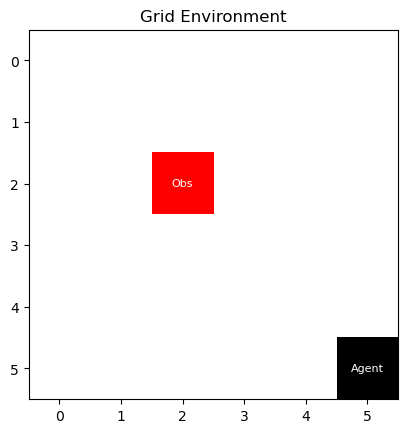

In [72]:
#########################################
## Single Episode of Testing The Agent ##
#########################################

observation, info = env.reset()
env.render()
index_lookup_table = np.arange(72).reshape((2,6,6))
def get_state_index(obs):
    return index_lookup_table[obs[0], obs[1], obs[2]]

state_idx = get_state_index(observation)

for step in range(50):
    action = np.argmax(Q_table[state_idx, :])
    
    if np.random.rand() < det:  # stochastic
        reward = -1
    else:
        obs, reward, terminated, truncated, info = env.step(action)
    
    new_state_idx = get_state_index(obs)
    state_idx = new_state_idx
    
    env.render()
    time.sleep(.1)  # TODO Pause to see the update
    
    clear_output(wait=True)  # Clear the previous output so the next plot replaces it
    
    if terminated:
        break

In [ ]:

state_idx = get_state_index(observation)

for step in range(50):
    action = np.argmax(Q_table[state_idx, :])
    
    if np.random.rand() < det:  # stochastic
        reward = -1
    else:
        obs, reward, terminated, truncated, info = env.step(action)
    
    new_state_idx = get_state_index(obs)
    state_idx = new_state_idx
    
    env.render()
    time.sleep(.1)  # TODO Pause to see the update
    
    clear_output(wait=True)  # Clear the previous output so the next plot replaces it
    
    if terminated:
        break

In [26]:
#########################################
########## Random Agent Class ###########
#########################################

class RandomAgent:

    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space


    def step(self, obs):
        """Takes a step in the environment by choosing an action randomly.

        Args:
            obs: The current observation.

        Returns:
            The action to take.
        """
        return np.random.choice(self.action_space.n)

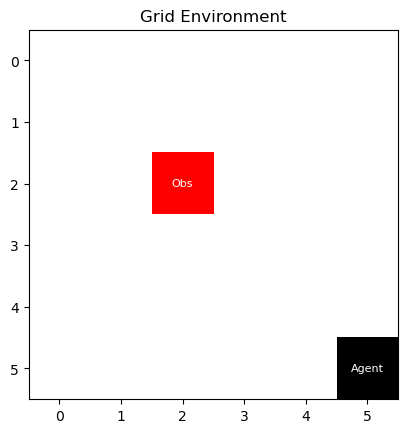

In [27]:
# Sample code for environment and agent implementation. Also shows
# visualization of the random agent's movement across the grid. The yellow cell
# shows the movement of the agent.

if __name__ == '__main__':
    env = GridEnvironment()
    random_agent = RandomAgent(env)

    obs, info = env.reset()
    terminated, truncated = False, False

    while not terminated:  # one episode:

        action = random_agent.step(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        # print('Action:', action, ', Reward:', reward, ', Done:', terminated)
        
        env.render()
        time.sleep(.05)  # TODO Pause to see the update
        
        clear_output(wait=True)  # Clear the previous output so the next plot replaces it